# Experiments 

In [1]:
# import packages
import requests
import json
import pandas as pd
import os
import openai
from openai import OpenAI
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

from visualization import *
from utils import *

In [2]:
# load ground truth data
ground_truth = pd.read_csv('./../data/cleaned_all_data.csv')
objects = list(ground_truth['prompt'].value_counts().head(4).index)
print(f"Top {len(objects)} of objects in the dataset: {objects}")

ocsai_eval_merged_gpt35_30 = pd.read_csv('./data_ocsai/merged_df/ocsai_eval_merged_30_gpt_3_5.csv')
ocsai_eval_merged_gpt4_30 = pd.read_csv('./data_ocsai/merged_df/ocsai_eval_merged_30_gpt_4.csv')

Top 4 of objects in the dataset: ['brick', 'box', 'knife', 'rope']



## Experiment 1

Test if creativity higher when we output 100 ideas at once or 4 times 25 ideas (closer to human behavior)

In [3]:
object = objects[3] # select the object
print(f"Selected object: {object}")

Selected object: rope


In [16]:
# Generate the 100 responses for the selected object
df = pipeline_object(object, 100)

for i in tqdm(range(len(df))):
    eval_ocsai = call_api_ocsai(df.loc[i, 'prompt'], df.loc[i, 'response'])
    df.loc[i, 'originality_ocsai'] = eval_ocsai['scores'][0]['originality']  # see if we can speed up eval if we pass batches of sentences
    df.loc[i, 'elaboration_ocsai'] = eval_ocsai['scores'][0]['elaboration']

# check if there are any NaNs
if df.isnull().values.any():
    print("There are NaNs in the DataFrame")
else:
    df.to_csv(f'./data_ocsai/data_exp1/aut_{object}_100.csv', index=False) 
    print("Saved successfully")

df.head()

System fingerprint: fp_a7daf7c51e
Prompt tokens: 199
Completion tokens: 1371
Estimated price: $0.04312


100%|██████████| 89/89 [02:13<00:00,  1.50s/it]

Saved successfully


,prompt,response,originality_ocsai,elaboration_ocsai
0,rope,Use it to create an outdoor swing for kids.,1.3,9.0
1,rope,Transform it into a stylish belt for your pant...,1.7,11.0
2,rope,Weave it into a durable and unique doormat.,2.7,8.0
3,rope,Utilize it as a makeshift tow line for small v...,1.3,10.0
4,rope,Braid it into a strong leash for your dog.,1.3,9.0


In [17]:
# Generate 4 times 25 responses for the selected object
dfs = {}

for N in range(4):
    print(f"Started generation round {N+1}...")
    dfs[N] = pipeline_object(object, 25)
    
    for i in tqdm(range(len(dfs[N]))):
        eval_ocsai = call_api_ocsai(dfs[N].loc[i, 'prompt'], dfs[N].loc[i, 'response'])
        dfs[N].loc[i, 'originality_ocsai'] = eval_ocsai['scores'][0]['originality']  # see if we can speed up eval if we pass batches of sentences
        dfs[N].loc[i, 'elaboration_ocsai'] = eval_ocsai['scores'][0]['elaboration']

# merge the 4 dataframes
df_merged = pd.concat([dfs[0], dfs[1], dfs[2], dfs[3]], ignore_index=True)
df_merged.head()

Started generation round 1...


System fingerprint: fp_a7daf7c51e
Prompt tokens: 199
Completion tokens: 350
Estimated price: $0.012490000000000001


100%|██████████| 25/25 [00:38<00:00,  1.56s/it]


Started generation round 2...
System fingerprint: fp_a7daf7c51e
Prompt tokens: 199
Completion tokens: 405
Estimated price: $0.014140000000000002


100%|██████████| 25/25 [00:37<00:00,  1.51s/it]


Started generation round 3...
System fingerprint: fp_a7daf7c51e
Prompt tokens: 199
Completion tokens: 409
Estimated price: $0.01426


100%|██████████| 25/25 [00:38<00:00,  1.55s/it]


Started generation round 4...
System fingerprint: fp_a7daf7c51e
Prompt tokens: 199
Completion tokens: 443
Estimated price: $0.01528


100%|██████████| 25/25 [00:42<00:00,  1.71s/it]


,prompt,response,originality_ocsai,elaboration_ocsai
0,rope,Create a hanging shelf for plants or books.,3.3,8.0
1,rope,Braid a thicker rope for a durable dog leash.,1.7,9.0
2,rope,Weave a basket or container for storing items.,2.0,8.0
3,rope,Craft a rustic picture frame.,2.7,5.0
4,rope,Make a swing for children or a hammock for rel...,1.3,11.0


In [18]:
# check if there are any NaNs
if df_merged.isnull().values.any():
    print("There are NaNs in the DataFrame")
else:
    df_merged.to_csv(f'./data_ocsai/data_exp1/aut_{object}_4x25.csv', index=False) 
    print("Saved successfully")

Saved successfully


## Analysis of the results

In [3]:
def load_data_exp1(model):
    """
    Load the data for the first experiment
    """
    # load data with 100 responses
    aut_box_100 = pd.read_csv(f'./data_ocsai/data_exp1/{model}/aut_box_100.csv')
    aut_brick_100 = pd.read_csv(f'./data_ocsai/data_exp1/{model}/aut_brick_100.csv')
    aut_knife_100 = pd.read_csv(f'./data_ocsai/data_exp1/{model}/aut_knife_100.csv')
    aut_rope_100 = pd.read_csv(f'./data_ocsai/data_exp1/{model}/aut_rope_100.csv')

    # load data with 4x25 responses
    aut_box_4x25 = pd.read_csv(f'./data_ocsai/data_exp1/{model}/aut_box_4x25.csv')
    aut_brick_4x25 = pd.read_csv(f'./data_ocsai/data_exp1/{model}/aut_brick_4x25.csv')
    aut_knife_4x25 = pd.read_csv(f'./data_ocsai/data_exp1/{model}/aut_knife_4x25.csv')
    aut_rope_4x25 = pd.read_csv(f'./data_ocsai/data_exp1/{model}/aut_rope_4x25.csv')

    # merge the dataframes
    ocsai_eval_merged_gpt35_100 = pd.concat([aut_box_100, aut_brick_100, aut_knife_100, aut_rope_100])
    ocsai_eval_merged_gpt35_4x25 = pd.concat([aut_box_4x25, aut_brick_4x25, aut_knife_4x25, aut_rope_4x25])
    #rename the columns originality
    ocsai_eval_merged_100 = ocsai_eval_merged_gpt35_100.rename(columns={"originality_ocsai": "originality", "elaboration_ocsai": "elaboration"})
    ocsai_eval_merged_4x25 = ocsai_eval_merged_gpt35_4x25.rename(columns={"originality_ocsai": "originality", "elaboration_ocsai": "elaboration"})
    
    return ocsai_eval_merged_100, ocsai_eval_merged_4x25

ocsai_eval_merged_gpt35_100, ocsai_eval_merged_gpt35_4x25 = load_data_exp1('gpt_35')
ocsai_eval_merged_gpt4_100, ocsai_eval_merged_gpt4_4x25 = load_data_exp1('gpt_4')

display(ocsai_eval_merged_gpt35_100.head(2), ocsai_eval_merged_gpt35_4x25.head(2), ocsai_eval_merged_gpt4_100.head(2), ocsai_eval_merged_gpt4_4x25.head(2))

,prompt,response,originality,elaboration
0,box,Use it as a makeshift stool for reaching high ...,1.7,10.0
1,box,Transform it into a mini-garden by adding soil...,3.0,10.0


,prompt,response,originality,elaboration
0,box,Use it as a mini herb garden by planting herbs...,3.0,11.0
1,box,Convert it into a unique wall shelf by adding ...,2.0,12.0


,prompt,response,originality,elaboration
0,box,Transform it into a mini garden for succulents.,3.0,8.0
1,box,Use it as a makeshift sled on snowy days.,2.0,9.0


,prompt,response,originality,elaboration
0,box,Transform it into a mini greenhouse for starti...,3.0,9.0
1,box,Cut out shapes and use it as a stencil for art...,3.0,12.0


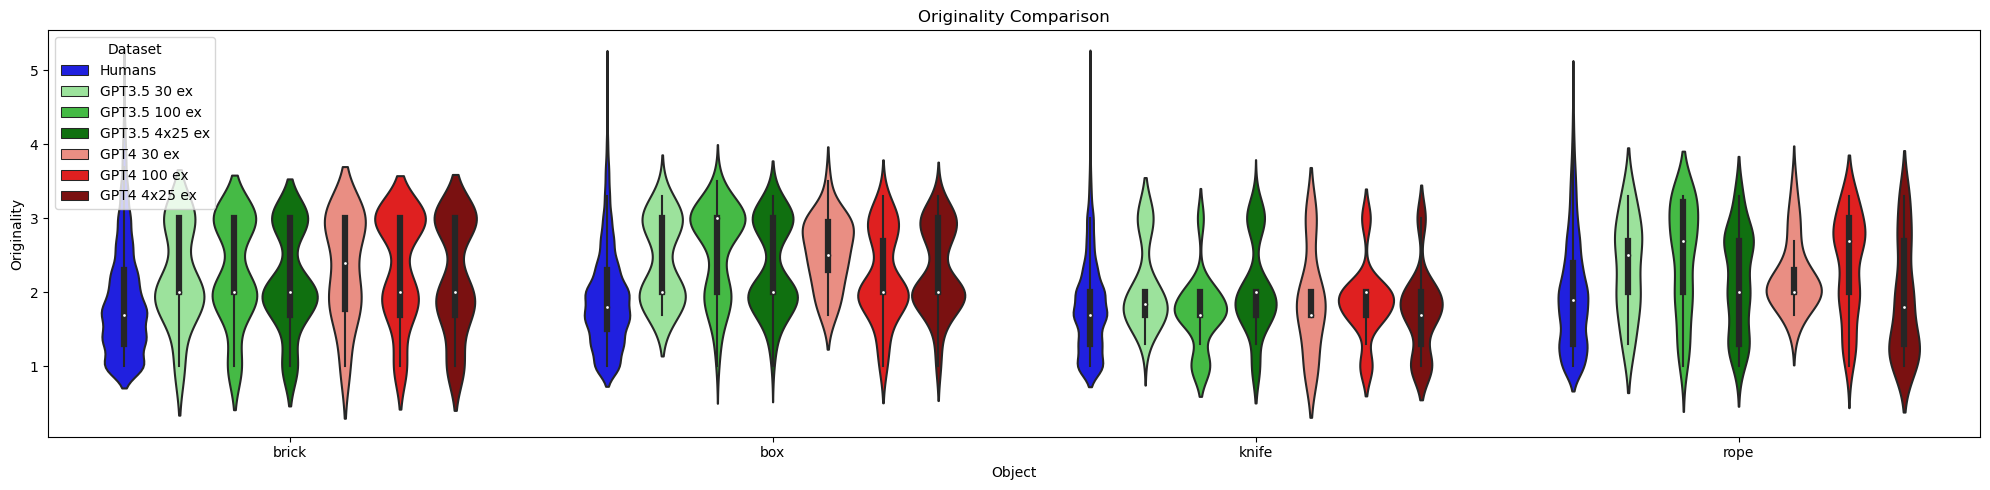

In [4]:
ground_truth_test = ground_truth.rename(columns={"target": "originality"})

combined_data = pd.concat([
    ground_truth_test.assign(dataset='Humans'),
    ocsai_eval_merged_gpt35_30.assign(dataset='GPT3.5 30 ex'),
    ocsai_eval_merged_gpt35_100.assign(dataset='GPT3.5 100 ex'),
    ocsai_eval_merged_gpt35_4x25.assign(dataset='GPT3.5 4x25 ex'),
    ocsai_eval_merged_gpt4_30.assign(dataset='GPT4 30 ex'),
    ocsai_eval_merged_gpt4_100.assign(dataset='GPT4 100 ex'),
    ocsai_eval_merged_gpt4_4x25.assign(dataset='GPT4 4x25 ex')
])
# Set up the figure and axes
plt.figure(figsize=(20, 5))


# Define a custom color palette
colors = {'Humans': 'blue', 'GPT3.5 30 ex': 'lightgreen', 'GPT3.5 100 ex': 'limegreen', 'GPT3.5 4x25 ex': 'green',
          'GPT4 30 ex': 'salmon', 'GPT4 100 ex': 'red', 'GPT4 4x25 ex': 'darkred'}

# Plot violin plots
sns.violinplot(x='prompt', y='originality', hue='dataset', data=combined_data[combined_data['prompt'].isin(objects)],
               order=objects, palette=colors.values())  # Use custom color palette

#sns.catplot(data=df, x="age", y="class", hue="sex", kind="violin")

plt.title('Originality Comparison')
plt.xlabel('Object')
plt.ylabel('Originality')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

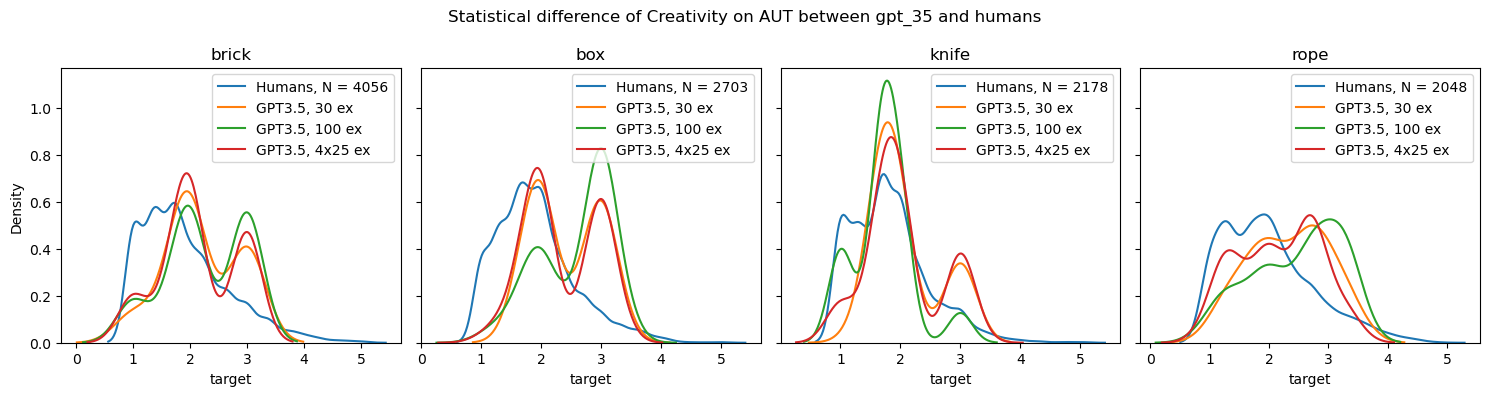

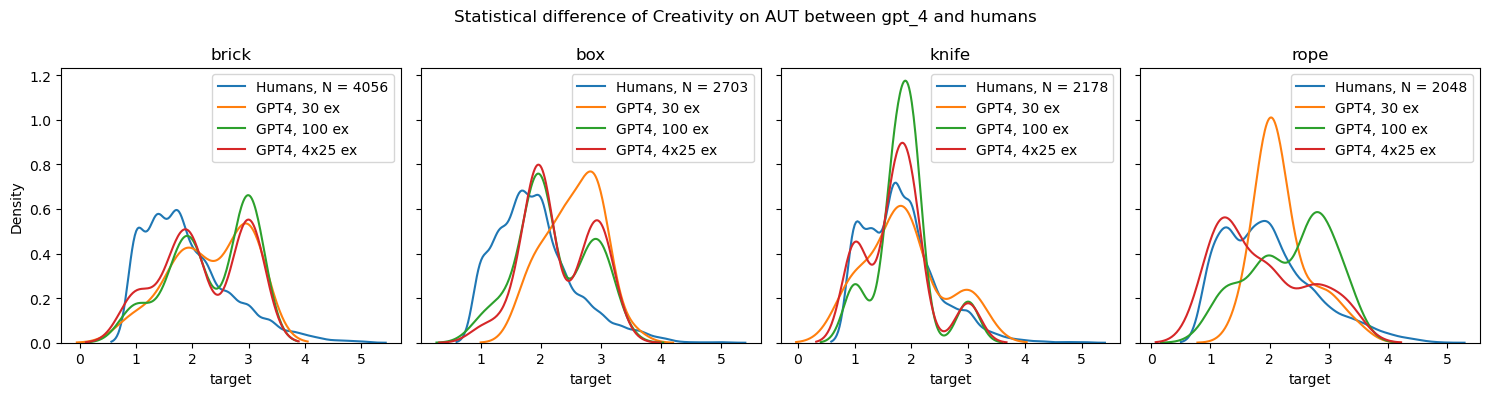

In [5]:
plot_kde_exp1('gpt_35', ocsai_eval_merged_gpt35_30, ocsai_eval_merged_gpt35_100, ocsai_eval_merged_gpt35_4x25, ocsai_eval_merged_gpt4_30, ocsai_eval_merged_gpt4_100, ocsai_eval_merged_gpt4_4x25)
plot_kde_exp1('gpt_4', ocsai_eval_merged_gpt35_30, ocsai_eval_merged_gpt35_100, ocsai_eval_merged_gpt35_4x25, ocsai_eval_merged_gpt4_30, ocsai_eval_merged_gpt4_100, ocsai_eval_merged_gpt4_4x25)

NOTE: Overall, generating 100 samples seem to be better than all the rest. Let's compare the 2 models now.

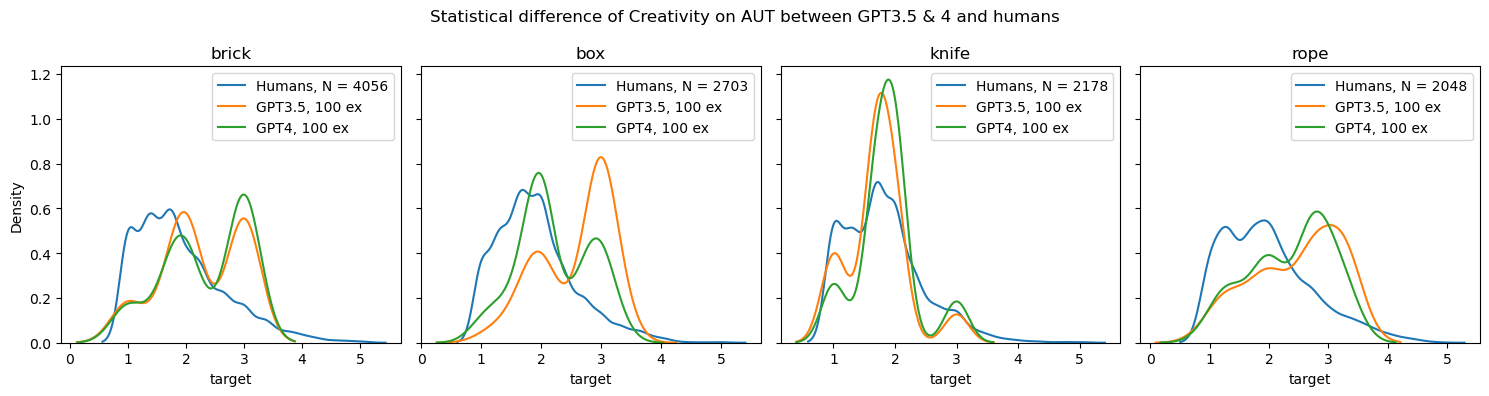

In [8]:
fig, axs = plt.subplots(1,4, figsize=(15, 4), sharey=True)
for i, object_name in enumerate(objects):
    # normalize the values in ground truth and ocsai_eval_merged
    object_ground_truth = ground_truth[ground_truth['prompt'] == object_name]
    object_ocsai_eval_gpt35_100 = ocsai_eval_merged_gpt35_100[ocsai_eval_merged_gpt35_100['prompt'] == object_name]
    object_ocsai_eval_gpt4_100 = ocsai_eval_merged_gpt4_100[ocsai_eval_merged_gpt4_100['prompt'] == object_name]
    
    sns.kdeplot(object_ground_truth['target'], label=f'Humans, N = {len(object_ground_truth)}', ax = axs[i])
    sns.kdeplot(object_ocsai_eval_gpt35_100['originality'], label=f'GPT3.5, 100 ex', ax = axs[i])
    sns.kdeplot(object_ocsai_eval_gpt4_100['originality'], label=f'GPT4, 100 ex', ax = axs[i])
    
    axs[i].set_title(f'{object_name}')
    axs[i].legend()
plt.suptitle(f'Statistical difference of Creativity on AUT between GPT3.5 & 4 and humans')
plt.tight_layout()
plt.show()

NOTE: GPT3.5 seems to be slightly better.